In [17]:
%reload_ext autoreload
%autoreload 2

from brian2 import *
from plotlib import *
from tqdm import tqdm

import experiment_12_thalamus as ex12
import pickle


In [24]:
n_mod = 998
start, end = 1000, 5000
dt, shift = 10, 5

In [ ]:
d = ex12.run_experiment(n_mod=1000, thalamus_modulation=2.0)

In [ ]:
plot_stuff(d, max_mod)

In [9]:

def ex12_mapper(modulation):
    return ex12.run_experiment(n_mod=n_mod, thalamus_modulation=modulation)

p = Pool(5)
modulation = np.linspace(0, 2, 5)
data_array = p.map(ex12_mapper, modulation)
p.close()

In [ ]:
len(data_array)

In [25]:
lzs = []
lzs = np.zeros((len(data_array), n_mod))

for idx, d in enumerate(data_array):
    sys.stdout.write("{}... ".format(idx))
    sys.stdout.flush()
    lzs[idx,:] = get_lz_comp(d, start, end, dt, shift)


0... 1... 2... 3... 4... 

In [20]:
with open('experiment_data/exp12_lz.pickle', 'wb') as f:
    pickle.dump(lzs, f)

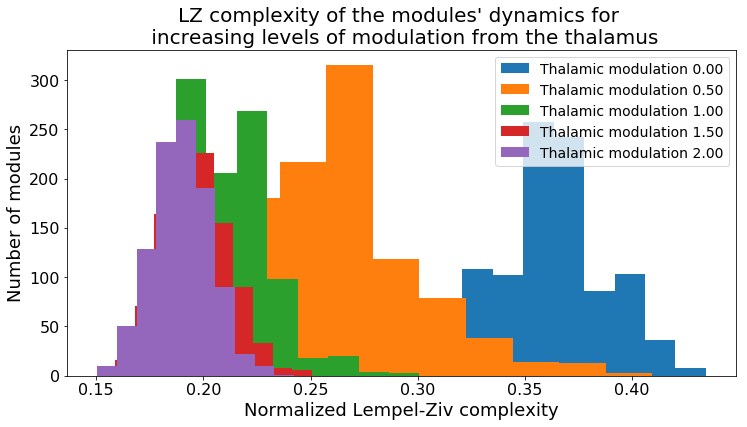

In [26]:

_, ax = plt.subplots(figsize=(12,6))
for lz_comp, mod in zip(lzs, modulation):#[::-1]:
    plot_lz(lz_comp, start, end, dt, shift, ax=ax, label='Thalamic modulation {:.2f}'.format(mod))
ax.set_xlabel('Normalized Lempel-Ziv complexity')
ax.set_ylabel('Number of modules')
ax.set_title('LZ complexity of the modules\' dynamics for \n increasing levels of modulation from the thalamus')
plt.legend()
#plt.savefig('figures/exp12_lz_thalamus_modulation.png')
plt.show()

In [ ]:

for d in data_array:
X = data_array[1]['X']
print("{:,}".format(len(X)))

In [ ]:
lzs[0].shape

In [ ]:
a = []
for i in tqdm(range(10)):
    x = 0
    for _ in np.arange(1e7):
        x += 1
    a.append((i, j))
print(a)

In [ ]:
data_array[0]